# Détection d'objets sur le dataset African Wildlife

In [33]:
import numpy as np
import matplotlib.pyplot as plt

import PIL
from PIL import Image
import os, sys

import keras
from keras.utils import np_utils
from keras import layers
from keras import models
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D, Input 
from keras.layers import Activation, BatchNormalization, SeparableConv2D, Add, Reshape, LeakyReLU
from keras.models import Model, Sequential
from keras.initializers import glorot_uniform, Constant

Le dataset vient de kaggle : https://www.kaggle.com/crained/wearingmaskc19

Le dataset contient 150 images. Sur chaque image il y des personnes qui portent ou ne portent pas de masques. 


## Préparation des données

In [2]:
BOX_PER_W_IMAGE=7
BOX_SIZE=32
IMAGE_SIZE=BOX_PER_W_IMAGE * BOX_SIZE
MAX_TRUE_BOX_PER_IMAGE = 5
BOX = 5
NUM_CLASSES=2

In [3]:
IMAGE_SIZE

224

In [4]:
def resize_and_save_to_numpy():
  ds_path = "./data/"
  images_paths = [ds_path+"train/images/", ds_path+"test/images/", ds_path+"valid/images/"]
  labels_paths = [ds_path+"train/labels/", ds_path+"test/labels/", ds_path+"valid/labels/"]
  x_train = np.zeros((106, IMAGE_SIZE, IMAGE_SIZE, 3))
  x_val = np.zeros((16+28, IMAGE_SIZE, IMAGE_SIZE, 3))
  y_train = np.zeros((106, BOX_PER_W_IMAGE,BOX_PER_W_IMAGE,BOX, 1+4*1+NUM_CLASSES))
  y_val = np.zeros((16+28, BOX_PER_W_IMAGE,BOX_PER_W_IMAGE,BOX, 1+4*1+NUM_CLASSES))

  for k in range(3):
    images_path=images_paths[k]
    images_dirs = os.listdir(images_path)
    images_dirs.sort()
    if k==2:
      i=15
    else:
      i=0
    for item in images_dirs:
      extension =item.split(".")[-1]
      if extension=="jpg" or extension=="JPG":
        img = Image.open(images_path+item)
        #print(img.size)
        f, e = os.path.splitext(images_path+item)
        img = img.resize((IMAGE_SIZE,IMAGE_SIZE), Image.ANTIALIAS)
        #print(img.size)
        if k==0:
          x_train[i]=np.asarray(img)
        else:
          x_val[i]=np.asarray(img)
        i+=1
      else:
        print("extension trouvée : ", extension)
    
    labels_path=labels_paths[k]
    labels_dirs = os.listdir(labels_path)
    labels_dirs.sort()
    if k==2:
      i=15
    else:
      i=0
    for item in labels_dirs:
      #print("IMAGE NUM ", i)
      extension =item.split(".")[-1]
      if extension=="txt":
        labels = open(labels_path+item, "r")
        labels= labels.read().split('\n')
        for label in labels:
            label=label.split()
            #print(label)
            ax, ay= float(label[1])*BOX_PER_W_IMAGE, float(label[2])*BOX_PER_W_IMAGE
            ind_x, ind_y = int(ax), int(ay)
            
            pred=np.array([1], dtype="i")
            classes = np_utils.to_categorical(label[0], num_classes=2)
            #classes = np.array(label[0], dtype="i")
            label[1] = ax - ind_x
            label[2] = ay - ind_y
            coordonnees = np.array(label[1:],dtype="f")
            arr_labels=np.append(np.append(pred,coordonnees),classes)
            #print(arr_labels)
            if k==0:
              p=0
              while p<BOX:
                if (y_train[i, ind_x, ind_y, p, 0] == 0 or p==BOX-1):
                  y_train[i, ind_x, ind_y, p]= arr_labels
                  break;
                else:
                  p+=1
            else:
              p=0
              while p<BOX:
                if (y_val[i, ind_x, ind_y, p, 0] == 0 or p==BOX-1):
                  y_val[i, ind_x, ind_y, p]= arr_labels
                  break;
                else:
                  p+=1
        i+=1
      else:
        print("extension trouvée : ", extension)
  return x_train/256,x_val/256,y_train, y_val

x_train, x_val, y_train, y_val = resize_and_save_to_numpy()

In [5]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((106, 224, 224, 3), (106, 7, 7, 5, 7), (44, 224, 224, 3), (44, 7, 7, 5, 7))

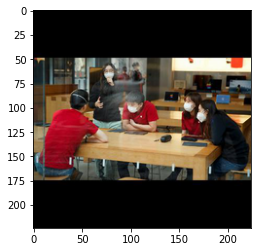

In [6]:
plt.imshow(x_val[42])

In [7]:
def get_true_boxes(x,y):
  x_true_boxes = np.zeros((x.shape[0], 1, 1, 1, MAX_TRUE_BOX_PER_IMAGE, 4))
  for i in range(x.shape[0]):
    j=0
    for index in get_boxes_index(y[i]):
      if j<MAX_TRUE_BOX_PER_IMAGE:
        x_true_boxes[i,0,0,0,j] = y[i,index[0],index[1],0,1:5]
      j+=1
  return x_true_boxes

In [8]:
SEUIL_DETECTION = 0.5

def get_boxes_index(y):
  indices= []
  for i in range(BOX_PER_W_IMAGE):
    for j in range(BOX_PER_W_IMAGE):
      for k in range(BOX):
        if y[i,j,k,0]>SEUIL_DETECTION and (indices == [] or indices[-1] != (i,j)):
          indices.append((i,j))
  return indices

In [9]:
x_train_true_boxes = get_true_boxes(x_train,y_train)
x_val_true_boxes = get_true_boxes(x_val,y_val)

In [10]:
x_train_true_boxes.shape, x_val_true_boxes.shape

((106, 1, 1, 1, 5, 4), (44, 1, 1, 1, 5, 4))

In [11]:
x_train_true_boxes[0]

array([[[[[0.35336539, 0.22836539, 0.06971154, 0.03365385],
          [0.89182693, 0.2235577 , 0.25      , 0.29326922],
          [0.81730771, 0.81730771, 0.09134615, 0.11057692],
          [0.22115384, 0.32932693, 0.07211538, 0.06009615],
          [0.76923078, 0.22115384, 0.0889423 , 0.11298077]]]]])

## Fonctions utiles

### Fonction de loss

In [12]:
IMAGE_H, IMAGE_W = IMAGE_SIZE, IMAGE_SIZE
OBJ_THRESHOLD    = 0.3#0.5
GRID_H,  GRID_W  = BOX_PER_W_IMAGE , BOX_PER_W_IMAGE
#ANCHORS           = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
NO_OBJECT_SCALE  = 0.5
OBJECT_SCALE     = 1
COORD_SCALE      = 5.0
CLASS_SCALE      = 1.0

CLASS            = 2
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
WARM_UP_BATCHES  = 0

In [13]:
def custom_loss(y_true, y_pred):
  mask_shape = tf.shape(y_true)[:4]

  cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), dtype=tf.float32)
  cell_y = tf.transpose(cell_x, (0,2,1,3,4))

  cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [tf.shape(y_true)[0], 1, 1, BOX, 1])
  
  coord_mask = tf.zeros(mask_shape)
  conf_mask  = tf.zeros(mask_shape)
  class_mask = tf.zeros(mask_shape)
  
  seen = tf.Variable(0.)
  
  total_AP = tf.Variable(0.)
  
  """
  Adjust prediction
  """
  ### adjust x and y      
  pred_box_xy = tf.sigmoid(y_pred[..., 1:3]) + cell_grid
  
  ### adjust w and h
  pred_box_wh = tf.exp(y_pred[..., 3:5]) #* np.reshape(ANCHORS, [1,1,1,BOX,2])
  
  ### adjust confidence
  pred_box_conf = tf.sigmoid(y_pred[..., 0])
  
  ### adjust class probabilities
  pred_box_class = y_pred[..., 5:]
  
  """
  Adjust ground truth
  """
  ### adjust x and y
  true_box_xy = y_true[..., 1:3] # relative position to the containing cell
  
  ### adjust w and h
  true_box_wh = y_true[..., 3:5] # number of cells accross, horizontally and vertically
  
  ### adjust confidence
  true_wh_half = true_box_wh / 2.
  true_mins    = true_box_xy - true_wh_half
  true_maxes   = true_box_xy + true_wh_half
  
  pred_wh_half = pred_box_wh / 2.
  pred_mins    = pred_box_xy - pred_wh_half
  pred_maxes   = pred_box_xy + pred_wh_half       
  
  intersect_mins  = tf.maximum(pred_mins,  true_mins)
  intersect_maxes = tf.minimum(pred_maxes, true_maxes)
  intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
  intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
  
  true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
  pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

  union_areas = pred_areas + true_areas - intersect_areas
  iou_scores  = tf.truediv(intersect_areas, union_areas)
  
  true_box_conf = iou_scores * y_true[..., 0]
  
  ### adjust class probabilities
  true_box_class = tf.argmax(y_true[...,5:], -1)
  true_box_class = tf.cast(true_box_class, dtype=tf.int32)    
  """
  Determine the masks
  """
  ### coordinate mask: simply the position of the ground truth boxes (the predictors)
  coord_mask = tf.expand_dims(y_true[..., 0], axis=-1) * COORD_SCALE
  
  ### confidence mask: penelize predictors + penalize boxes with low IOU
  # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
  true_xy = true_boxes[..., 0:2]
  true_wh = true_boxes[..., 2:4]
  
  true_wh_half = true_wh / 2.
  true_mins    = true_xy - true_wh_half
  true_maxes   = true_xy + true_wh_half
  
  pred_xy = tf.expand_dims(pred_box_xy, 4)
  pred_wh = tf.expand_dims(pred_box_wh, 4)
  
  pred_wh_half = pred_wh / 2.
  pred_mins    = pred_xy - pred_wh_half
  pred_maxes   = pred_xy + pred_wh_half    
  
  intersect_mins  = tf.maximum(pred_mins,  true_mins)
  intersect_maxes = tf.minimum(pred_maxes, true_maxes)
  intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
  intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
  
  true_areas = true_wh[..., 0] * true_wh[..., 1]
  pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

  union_areas = pred_areas + true_areas - intersect_areas
  iou_scores  = tf.truediv(intersect_areas, union_areas)

  best_ious = tf.reduce_max(iou_scores, axis=4)
  conf_mask = conf_mask + tf.cast(best_ious < 0.6,dtype=tf.float32) * (1 - y_true[..., 0]) * NO_OBJECT_SCALE
  
  # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
  conf_mask = conf_mask + y_true[..., 0] * OBJECT_SCALE
  
  ### class mask: simply the position of the ground truth boxes (the predictors)
  class_mask = y_true[..., 0] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
  
  """
  Warm-up training
  """
  no_boxes_mask = tf.cast(coord_mask < COORD_SCALE/2., dtype=tf.float32)
  seen = tf.assign_add(seen, 1.)
  
  true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                        lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                  true_box_wh + tf.ones_like(true_box_wh) * \
                                  #np.reshape(ANCHORS, [1,1,1,BOX,2]) * \
                                  no_boxes_mask, 
                                  tf.ones_like(coord_mask)],
                        lambda: [true_box_xy, 
                                  true_box_wh,
                                  coord_mask])
  
  """
  Finalize the loss
  """
  nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0,dtype=tf.float32))
  nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0,dtype=tf.float32))
  nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0,dtype=tf.float32))
  

  loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
  
  loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
  loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
  
  loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
  loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
  
  loss = loss_xy + loss_wh + loss_conf + loss_class

  nb_true_box = tf.reduce_sum(y_true[..., 0])
  nb_pred_box = tf.reduce_sum(tf.cast(true_box_conf > 0.5, dtype=tf.float32) * tf.cast(pred_box_conf > OBJ_THRESHOLD,dtype=tf.float32))
  
  total_AP = tf.assign_add(total_AP, nb_pred_box/nb_true_box) 
  
  loss = tf.Print(loss, [loss_xy, loss_wh, loss_conf, loss_class, loss, total_AP/seen], message='DEBUG', summarize=1000)
  
  return loss

### Fonction de metrics

In [14]:
def get_iou(y_true, y_pred):
  iou_scores=[]
  index=1
  for i in range(y_true.shape[0]):
    for i1,i2 in get_boxes_index(y_true[i]):
      p=0
      boucle=True
      while (p<BOX and boucle):
        if y_true[i, i1, i2 , p, 0]>0:
          ### adjust x and y
          pred_box_xy = y_pred[i, i1, i2 , p, index:index+2]
          true_box_xy = y_true[i, i1, i2 , p, index:index+2]

          ### adjust w and h
          pred_box_wh = y_pred[i, i1, i2, p, index+2:index+4]
          true_box_wh = y_true[i, i1, i2, p, index+2:index+4]
          
          true_wh_half = true_box_wh / 2.
          true_mins    = true_box_xy - true_wh_half
          true_maxes   = true_box_xy + true_wh_half

          pred_wh_half = pred_box_wh / 2.
          pred_mins    = pred_box_xy - pred_wh_half
          pred_maxes   = pred_box_xy + pred_wh_half       
          
          intersect_mins  = np.maximum(pred_mins,  true_mins)
          intersect_maxes = np.minimum(pred_maxes, true_maxes)
          intersect_wh    = np.maximum(intersect_maxes - intersect_mins, 0.)

          intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

          true_areas = true_box_wh[0] * true_box_wh[1]
          pred_areas = pred_box_wh[0] * pred_box_wh[1]

          union_areas = pred_areas + true_areas - intersect_areas
          iou=intersect_areas/union_areas
          if iou>=0:
            iou_scores = np.append(iou_scores, iou)
          p+=1
        else:
          boucle=False
  return np.mean(iou_scores)

In [15]:
get_iou(y_train, y_train)

<ipython-input-14-6cc0c8e08f09>:36: RuntimeWarning: invalid value encountered in double_scalars
  iou=intersect_areas/union_areas


1.0

### Fonction d'entrainement

In [16]:
from keras.optimizers import Adam, RMSprop, SGD

import tensorflow as tf
batch_size=16
def train(model, x_train, x_train_true_boxes, y_train, x_val, y_val,
          augmentation_donnees=False, epochs=50, lr=1e-4,nb_outputs=1,loss="MSE"):
  opt = Adam(learning_rate=lr)  
  #opt=RMSprop(lr)
  #opt=SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
  if nb_outputs==1: 
    if loss=="custom":
      #loss=yolo_loss
      loss=custom_loss
    else :
      loss="MSE"
    metrics=['mae']
    loss_weights=[1]
  else:
    loss=["binary_crossentropy","MSE","categorical_crossentropy"]
    metrics=[
              ['accuracy'],
              ['mae'],
              ['accuracy']
            ]
    loss_weights=[1,5,1]

  model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )

  if augmentation_donnees:
    history = model.fit_generator(
      train_gen,
      epochs=epochs,
      validation_data=val_gen,
      workers=2, 
      use_multiprocessing=False)
  else:
    history = model.fit(
              [x_train, x_train_true_boxes], 
              y_train,
              epochs=epochs,
              batch_size=batch_size,            
              validation_data=([x_val, x_val_true_boxes], y_val))
  return history

### Visualisation des images

In [17]:
labels={
    0: "Masque",
    1: "Pas de masque",
}

In [18]:
def get_class(y,i,j):
  if y[i,j,0,0] <= SEUIL_DETECTION:
    return "Aucun objet détecté"
  else:
    return np.where(y[i,j,0][5:] == y[i,j,0][5:].max())[0][0]

#Test
num_img=0
num_box=2
boxes = get_boxes_index(y_train[num_img])
print("Classe (image n°{}, box n°{}) : {}".format(num_img, num_box, labels.get(get_class(y_train[num_img], boxes[0][0],boxes[0][1]))))

Classe (image n°0, box n°2) : Masque


In [19]:
def get_boxes_coord(y):
  coord=[]
  for i,j in get_boxes_index(y):
    for k in range(BOX):
      y_coord = y[i,j,k,:]
      classe = get_class(y, i, j)
      if y_coord[0] > SEUIL_DETECTION:
        coord.append(
            np.array(
                [float(y_coord[0]),
                int(y_coord[1]*BOX_SIZE)+i*BOX_SIZE,
                int(y_coord[2]*BOX_SIZE)+j*BOX_SIZE,
                y_coord[3]*IMAGE_SIZE,
                y_coord[4]*IMAGE_SIZE,
                classe]
                #y[i,j,3]**2*IMAGE_SIZE,
                #y[i,j,4]**2*IMAGE_SIZE]
            )
    )
  return np.array(coord)

get_boxes_coord(y_train[0])

array([[  1.        ,  11.        ,  39.        ,  15.6153841 ,
          7.53846192,   0.        ],
       [  1.        ,  28.        , 135.        ,  56.        ,
         65.69230461,   0.        ],
       [  1.        ,  58.        ,  58.        ,  20.46153808,
         24.76923013,   0.        ],
       [  1.        ,  71.        ,  42.        ,  16.15384603,
         13.46153808,   1.        ],
       [  1.        ,  93.        ,  43.        ,  14.53846192,
         15.07692385,   1.        ],
       [  1.        ,  77.        ,  58.        ,  21.        ,
         29.6153841 ,   1.        ],
       [  1.        , 120.        ,  71.        ,  19.92307615,
         25.30769205,   1.        ],
       [  1.        , 108.        ,  96.        ,  23.15384603,
         31.2307682 ,   0.        ],
       [  1.        , 129.        ,  63.        ,  17.23076987,
         22.07692385,   1.        ],
       [  1.        , 150.        ,  53.        ,  19.3846159 ,
         24.76923013,   1. 

p: 1.0, x: 30.0, y: 74.0, w: 44.69230794906616, h:59.76923179626465
p: 1.0, x: 95.0, y: 92.0, w: 40.923076152801514, h:46.30769205093384
p: 1.0, x: 91.0, y: 152.0, w: 93.69230461120605, h:63.5384635925293
p: 1.0, x: 99.0, y: 51.0, w: 25.84615397453308, h:28.0
p: 1.0, x: 144.0, y: 51.0, w: 26.384615898132324, h:28.0
p: 1.0, x: 166.0, y: 91.0, w: 37.69230794906616, h:44.15384769439697
p: 1.0, x: 198.0, y: 51.0, w: 35.53846025466919, h:26.923076152801514


Text(0.5, 1.0, 'Image 61')

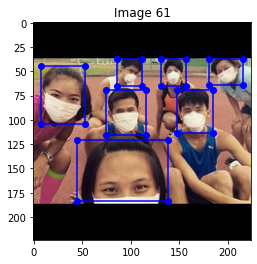

In [20]:
def print_data(x,y):
  plt.imshow(x)
  boxes = get_boxes_coord(y)
  for boxe in boxes:
    p, ax, ay, width, height, classe = boxe
    if classe==0:
      color = 'blue'
    else:
      color='red'
    print("p: {}, x: {}, y: {}, w: {}, h:{}".format(p,ax,ay,width, height))
    p_x=[ax-width/2,ax+width/2]
    p_y=[ay-height/2, ay+height/2]
    plt.plot([p_x[0], p_x[0]],p_y,color=color)
    plt.plot([p_x[1], p_x[1]],p_y,color=color)
    plt.plot(p_x,[p_y[0],p_y[0]],color=color)
    plt.plot(p_x,[p_y[1],p_y[1]],color=color)
    for px in p_x:
      for py in p_y:
        plt.scatter(px,py, color=color)

#num_img=np.random.randint(x_val.shape[0]-1)
#print_data(x_val[num_img],y_val[num_img])
num_img = np.random.randint(x_train.shape[0]-1)
print_data(x_train[num_img],y_train[num_img])
plt.title("Image {}".format(num_img))

### Fonctions d'analyse de l'entrainement
fonction permettant d'afficher les graphs de la mae et de la loss

In [21]:
def plot_training_analysis_mse(history):    
  mae = history.history['mae']
  val_mae = history.history['val_mae']
  #iou = history.history['IoU']
  #val_iou = history.history['val_IoU']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(mae))

  plt.plot(epochs, mae, 'b', linestyle="--",label='Training mae')
  plt.plot(epochs, val_mae, 'g', label='Validation mae')
  plt.title('Training and validation mae')
  plt.legend()

  """
  plt.figure()
  plt.plot(epochs, iou, 'b', linestyle="--",label='Training IoU')
  plt.plot(epochs, val_iou, 'g', label='Validation IoU')
  plt.title('Training and validation IoU')
  plt.legend()
  """
  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [22]:
def plot_training_analysis(history): 
  #metrics
  p_accuracy = history.history['p_accuracy']
  val_p_accuracy = history.history['val_p_accuracy']
  coord_mae = history.history['coord_mae']
  val_coord_mae = history.history['val_coord_mae']
  classes_accuracy = history.history['classes_accuracy']
  val_classes_accuracy = history.history['val_classes_accuracy']

  epochs=range(len(p_accuracy))

  plt.figure(figsize=(9,9))
  #plt.semilogy(epochs, p_accuracy, 'b', linestyle="--",label='Training P acc')
  #plt.semilogy(epochs, val_p_accuracy, 'g', label='Validation P acc')
  plt.semilogy(epochs, coord_mae,  linestyle="--",label='Training coord mae')
  plt.semilogy(epochs, val_coord_mae,  label='Validation coord mae')
  plt.semilogy(epochs, classes_accuracy,  linestyle="--",label='Training classes acc')
  plt.semilogy(epochs, val_classes_accuracy,  label='Validation classes acc')
  plt.title('Training and validation metrics')
  plt.legend()

  #loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  p_loss = history.history['p_loss']
  val_p_loss = history.history['val_p_loss']
  coord_loss = history.history['coord_loss']
  val_coord_loss = history.history['val_coord_loss']
  classes_loss = history.history['classes_loss']
  val_classes_loss = history.history['val_classes_loss']

  plt.figure(figsize=(9,9))
  plt.semilogy(epochs, loss, 'b', linestyle="--",label='Global training loss')
  plt.semilogy(epochs, val_loss,'g', label='Global validation loss')
  #plt.semilogy(epochs, p_loss, linestyle="--",label='Training P loss')
  #plt.semilogy(epochs, val_p_loss, label='Validation P loss')
  plt.semilogy(epochs, coord_loss, linestyle="--",label='Training coord loss')
  plt.semilogy(epochs, val_coord_loss, label='Validation coord loss')  
  plt.semilogy(epochs, classes_loss, linestyle="--",label='Training classes loss')
  plt.semilogy(epochs, val_classes_loss, label='Validation classes loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

### Analyse des prédictions

*   Affiche la classe prédite pour une image donnée

In [23]:
def print_predict_classes(x, y_true, y_pred, num_img):
  boxe_index = get_boxes_index(y_true[num_img])
  print(boxe_index)
  boxe_index = boxe_index[0]
  classe = get_class(y_true[num_img], boxe_index[0], boxe_index[1])
  plt.bar(labels.values(), y_pred[num_img, boxe_index[0], boxe_index[1],0][5:])
  for i in range(5,5+NUM_CLASSES):
    value=y_pred[num_img, boxe_index[0], boxe_index[1],0][i]*100
    str_value="%.2f" %value
    plt.text(i-5,value/100+0.02,str_value,horizontalalignment='center',fontsize=14)
  plt.xlabel("Classes")
  plt.ylabel("Probabilités prédites")
  plt.ylim(0,1)
  plt.title("Image {} ({})".format(num_img, labels.get(classe)))
  plt.show()

*   Affiche l'accuracy sur la prédiction de chaque classe.



In [24]:
def plot_classes_predictions(y_true, y_pred):
  predictions_count=np.zeros((NUM_CLASSES,2))
  for i in range(y_true.shape[0]):
    boxes_index = get_boxes_index(y_true[i])
    for boxe_index in boxes_index:
      true_class = get_class(y_true[i], boxe_index[0], boxe_index[1])
      pred_class = get_class(y_pred[i], boxe_index[0], boxe_index[1])
      predictions_count[true_class][0] += 1
      if true_class==pred_class:
        predictions_count[true_class][1] += 1
  predictions_avg=[predictions_count[i][1]/predictions_count[i][0]*100 for i in range(NUM_CLASSES)]
  global_accuracy=sum(predictions_count[:,1])/sum(predictions_count[:,0])*100
  global_accuracy="%.2f" %global_accuracy
  plt.bar(labels.values(), predictions_avg)
  for i in range(NUM_CLASSES):
    value=predictions_avg[i]
    str_value="%.2f" %value
    plt.text(i,value+2,str_value,horizontalalignment='center',fontsize=14)
  plt.xlabel("Classes")
  plt.ylabel("Accuracy")
  plt.ylim(0,100)
  plt.title("Global Accuracy : {}%". format(global_accuracy))
  plt.show()

*   Affichage de quelques prédictions d'animaux

In [25]:
def print_rd_predictions(x_true, y_true, y_pred, n=3):
  for i in range(1,n+1):
    num_img=np.random.randint(x_true.shape[0]-1)
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.title("Image {}".format(num_img))
    print_data(x_true[num_img],y_pred[num_img])
    plt.subplot(1,2,2)
    print_predict_classes(x_true, y_true, y_pred, num_img)

## Construction des modèles



### Modèle habituel

In [26]:
true_boxes=Input(shape=(1, 1, 1, MAX_TRUE_BOX_PER_IMAGE , 4))

In [27]:
def create_model_perso(dropout=False):
  model=Sequential()

  input_layer = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))

  x = Conv2D(64,(3,3))(input_layer)
  x = BatchNormalization(axis=3)(x)
  #model.add(Activation('relu'))
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPool2D(pool_size=(2,2))(x)
  
  x = Conv2D(128,(3,3))(x)
  x = BatchNormalization(axis=3)(x)
  #model.add(Activation('relu'))
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPool2D(pool_size=(2,2))(x)

  x = Conv2D(256,(3,3))(x)
  x = BatchNormalization(axis=3)(x)
  #model.add(Activation('relu'))
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPool2D(pool_size=(2,2))(x)

  x = Conv2D(512,(3,3))(x)
  x = BatchNormalization(axis=3)(x)
  #model.add(Activation('relu'))
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPool2D(pool_size=(2,2))(x)

  x = GlobalAveragePooling2D()(x)
  #x = Flatten()(x)
  if dropout:
    x = Dropout(0.5)(x)

  #x = Dense(1024)(x)
  #x = LeakyReLU(alpha=0.1)(x)

  output_size=BOX_PER_W_IMAGE*BOX_PER_W_IMAGE*BOX*(5+NUM_CLASSES)
  x = Dense(output_size)(x)
  x = Activation("linear")(x)
  
  x = Reshape((BOX_PER_W_IMAGE, BOX_PER_W_IMAGE, BOX, 5+NUM_CLASSES))(x)

  output = layers.Lambda(lambda args: args[0])([x, true_boxes])
  
  model = Model([input_layer, true_boxes], output, name='Model')

  return model

### Xception

In [34]:
def residual_middle_block(X, f, num_block, block):
  # définition du nom des couches
  conv_name_base = 'res' + str(num_block) + block + "_branch"
  
  # Sauvegarde de la valeur d'entrée
  X_skip_connection = X

  X=Activation('relu')(X)
  X=SeparableConv2D(f, (3,3), padding="same", name=conv_name_base+"a", kernel_initializer=kernel_init, bias_initializer=bias_init)(X)

  X=Activation('relu')(X)
  X=SeparableConv2D(f, (3,3), padding="same", name=conv_name_base+"b", kernel_initializer=kernel_init, bias_initializer=bias_init)(X)

  X=Activation('relu')(X)
  X=SeparableConv2D(f, (3,3), padding="same", name=conv_name_base+"c" , kernel_initializer=kernel_init, bias_initializer=bias_init)(X)
  
  X_skip_connection = Conv2D(f,(1,1),padding="same",kernel_initializer=kernel_init, bias_initializer=bias_init)(X_skip_connection)
  X = Add()([X, X_skip_connection])
  
  #Activation ReLU
  #X = Activation('relu')(X)
  X = LeakyReLU(alpha=0.1)(X)
  
  return X

In [35]:
def residual_block(X, f, num_block, block):
  # définition du nom des couches
  conv_name_base = 'res' + str(num_block) + block + "_branch"
  bn_name_base = 'bn' + str(num_block) + block + "_branch"
  pool_name_base = 'pool' + str(num_block) + block + "_branch"

  #Taille des filtres
  f1, f2 = f
  # Sauvegarde de la valeur d'entrée
  X_skip_connection = X

  #X=Activation('relu')(X)
  X = LeakyReLU(alpha=0.1)(X)

  X=SeparableConv2D(f1, (3,3), padding="same", name=conv_name_base+"a", kernel_initializer=kernel_init, bias_initializer=bias_init)(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + 'a')(X)

  #X=Activation('relu')(X)
  X = LeakyReLU(alpha=0.1)(X)
  X=SeparableConv2D(f2, (3,3),  padding="same", name=conv_name_base+"b", kernel_initializer=kernel_init, bias_initializer=bias_init)(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + 'b')(X)

  X=MaxPool2D((3,3), strides=(2,2), padding="same", name=pool_name_base)(X)
  
  X_skip_connection = Conv2D(filters = f2, 
                      kernel_size = (1, 1), 
                      strides = (2,2), 
                      padding = 'valid', 
                      name = conv_name_base + 'c',
                      kernel_initializer = glorot_uniform(seed=0)
                      ) (X_skip_connection)
  
  X_skip_connection = BatchNormalization(axis = 3, name = bn_name_base + '1') (X_skip_connection)
  X = Add()([X, X_skip_connection])
  
  #Activation ReLU
  #X = Activation('relu')(X)
  X = LeakyReLU(alpha=0.1)(X)
  
  
  return X

In [36]:
kernel_init = glorot_uniform()
bias_init = Constant(value=0.2)

In [37]:
true_boxes=Input(shape=(1, 1, 1, MAX_TRUE_BOX_PER_IMAGE , 4))

In [38]:
def create_model_xception(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), dropout=False):
  input_layer = Input(shape=input_shape)
  x = Conv2D(32, (3, 3),
              #strides=(2, 2),
              kernel_initializer=kernel_init, 
              bias_initializer=bias_init,
              name='block1_conv1',
              )(input_layer)
  x = BatchNormalization(axis=3, name='block1_conv1_bn')(x)
  #x = Activation('relu')(x)
  x = LeakyReLU(alpha=0.1)(x)
  
  #x = Conv2D(64, (3, 3), kernel_initializer=kernel_init, bias_initializer=bias_init, name='block1_conv2')(x)
  #x = BatchNormalization(axis=3, name='block1_conv2_bn')(x)
  #x = Activation('relu')(x)

  x = residual_block(x, [32, 32], 1, 'a')
  x = residual_block(x, [64, 64], 1, 'b')
  x = residual_block(x, [128, 128], 1, 'c')
  x = residual_block(x, [256, 256], 1, 'd')
  #x = residual_block(x, [512, 512], 1, 'e')

  #x = residual_middle_block(x, 32, 2, 'a')
  #x = residual_middle_block(x, 64, 2, 'b')
  #x = residual_middle_block(x, 128, 2, 'c')
  #x = residual_middle_block(x, 256, 2, 'd')

  #x = residual_block(x, [256, 384], 3, 'a')

  x=SeparableConv2D(384, (3,3), padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  #x=Activation('relu')(x)
  x = LeakyReLU(alpha=0.1)(x)

  x=SeparableConv2D(512, (3,3), padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  #x=Activation('relu')(x)
  x = LeakyReLU(alpha=0.1)(x)

  x=GlobalAveragePooling2D(name="avg_pool")(x)
  if dropout:
    x=Dropout(0.5)(x)
  
  output_size=BOX_PER_W_IMAGE*BOX_PER_W_IMAGE*BOX*(5+NUM_CLASSES)

  output= Dense(output_size, activation="linear")(x)
  output= Reshape((BOX_PER_W_IMAGE, BOX_PER_W_IMAGE, BOX, 5+NUM_CLASSES), name="output")(output)
 
  output = layers.Lambda(lambda args: args[0])([output, true_boxes])
  model = Model([input_layer, true_boxes], output, name='Xception')

  return model

### Fine-tuning

In [39]:
from keras.applications import ResNet50V2, VGG16, Xception

class BaseFeatureExtractor(object):
    """docstring for ClassName"""

    # to be defined in each subclass
    def __init__(self, input_size):
        raise NotImplementedError("error message")

    # to be defined in each subclass
    def normalize(self, image):
        raise NotImplementedError("error message")       

    def get_output_shape(self):
        return self.feature_extractor.get_output_shape_at(-1)[1:3]

    def extract(self, input_image):
        return self.feature_extractor(input_image)

class ResNet50Feature(BaseFeatureExtractor):
  """docstring for ClassName"""
  def __init__(self, input_size):
    conv_base = VGG16(input_shape=(input_size, input_size, 3), include_top=False)
    conv_base.trainable = True
    """XCEPTION
    for layer in conv_base.layers:
      if layer.name.split("_")[0] == "conv5":
        if layer.name.split("_")[1] == "block3":
          print(layer.name)
          layer.trainable = True  
        else:
          layer.trainable = False  
      else:
        layer.trainable = False
    """
    """VGG-16"""
    for layer in conv_base.layers:
      if layer.name.split("_")[0] == "block5":
        print(layer.name)
        #layer.trainable = True 
        layer.trainable = False
      else:
        layer.trainable = False
    #resnet50.load_weights(RESNET50_BACKEND_PATH)
    conv_base.layers.pop() # remove the average pooling layer
    self.feature_extractor = Model(conv_base.layers[0].input, conv_base.layers[-1].output)

  def normalize(self, image):
    #image = image[..., ::-1]
    #image = image.astype('float')

    #image[..., 0] -= 103.939
    #image[..., 1] -= 116.779
    #image[..., 2] -= 123.68

    return image

In [42]:
def create_model_ft(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)):
    input_layer= Input(shape=input_shape)
    #x = conv_base(input_layer)
    #x = Dropout(0.5)(x)
    #output_size=BOX_PER_W_IMAGE*BOX_PER_W_IMAGE*BOX*(5+NUM_CLASSES)
    #x = Dense(output_size)(x)
    #x = LeakyReLU(alpha=0.1)(x)
    feature_extractor = ResNet50Feature(IMAGE_SIZE)
    print(feature_extractor.get_output_shape())
    features = feature_extractor.extract(input_layer)

    #x = Dense(output_size, activation='linear')(x)
    x = Conv2D(BOX * (4 + 1 + NUM_CLASSES), 
                        (1,1), strides=(2,2), 
                        padding='same', 
                        name='DetectionLayer', 
                        kernel_initializer='lecun_normal')(features)
    x = Reshape((BOX_PER_W_IMAGE, BOX_PER_W_IMAGE, BOX, 5+NUM_CLASSES))(x)

    output = layers.Lambda(lambda args: args[0])([x, true_boxes])
    model = Model([input_layer, true_boxes], output, name='Fine-tuning')
    return model

## Avec une MSE globale

In [43]:
true_boxes=Input(shape=(1, 1, 1, MAX_TRUE_BOX_PER_IMAGE , 4))
model_mse = create_model_ft()
model_mse.summary()

block5_conv1
block5_conv2
block5_conv3
block5_pool


RuntimeError: The layer has never been called and thus has no defined output shape.

### Entrainement

In [ ]:
history_mse = train(model_mse, x_train, x_train_true_boxes, y_train, x_val, y_val, epochs=20, lr=1e-3, loss="MSE")

Train on 106 samples, validate on 44 samples
Epoch 1/20
106/106 [==============================] - 79s 742ms/step - loss: 0.1637 - mae: 0.2994 - val_loss: 0.0925 - val_mae: 0.2171
Epoch 2/20
106/106 [==============================] - 75s 707ms/step - loss: 0.0740 - mae: 0.1918 - val_loss: 0.0594 - val_mae: 0.1736
Epoch 3/20
106/106 [==============================] - 75s 705ms/step - loss: 0.0532 - mae: 0.1629 - val_loss: 0.0473 - val_mae: 0.1535
Epoch 4/20
106/106 [==============================] - 75s 705ms/step - loss: 0.0422 - mae: 0.1427 - val_loss: 0.0393 - val_mae: 0.1382
Epoch 5/20
106/106 [==============================] - 75s 703ms/step - loss: 0.0359 - mae: 0.1306 - val_loss: 0.0354 - val_mae: 0.1308
Epoch 6/20
106/106 [==============================] - 74s 702ms/step - loss: 0.0322 - mae: 0.1232 - val_loss: 0.0320 - val_mae: 0.1233
Epoch 7/20
106/106 [==============================] - 74s 701ms/step - loss: 0.0291 - mae: 0.1158 - val_loss: 0.0293 - val_mae: 0.1174
Epoch 8/20

### Analyse de l'entrainement

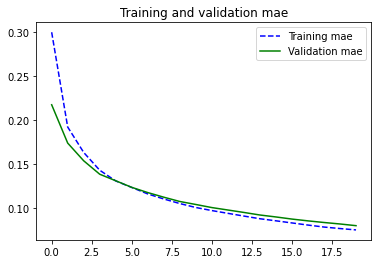

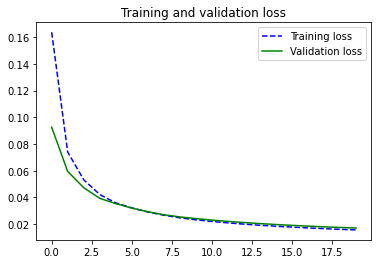

In [ ]:
plot_training_analysis_mse(history_mse)

In [ ]:
y_val_pred= model_mse.predict([x_val, x_val_true_boxes])
y_train_pred= model_mse.predict([x_train, x_train_true_boxes])

p: 0.5094456672668457, x: 100.0, y: 37.0, w: 3.4868054389953613, h:24.692420959472656
[(0, 1), (1, 1), (1, 3), (2, 1), (2, 2), (2, 3), (3, 2), (3, 3), (4, 3), (5, 2), (5, 3), (6, 2), (6, 3)]


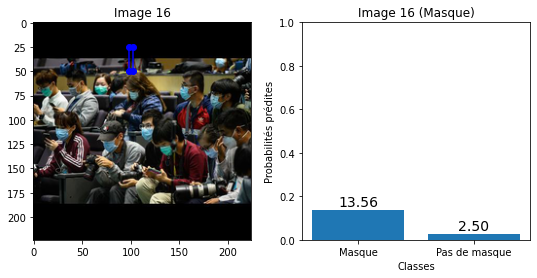

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 4), (5, 1), (5, 2), (5, 3), (6, 1), (6, 2), (6, 3), (6, 4)]


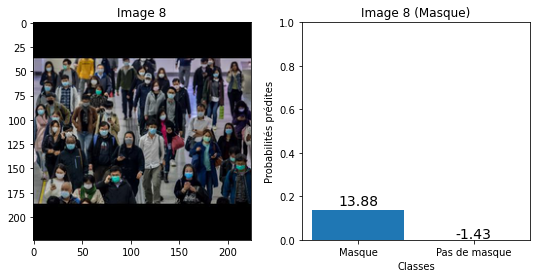

[(0, 2), (2, 2), (3, 3), (4, 2), (4, 3), (5, 2)]


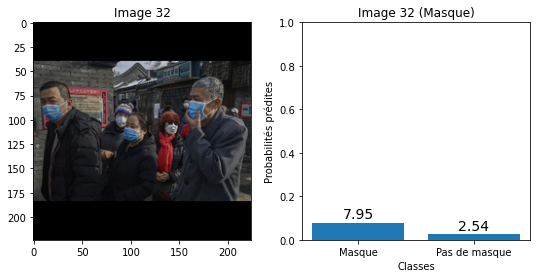

In [ ]:
print_rd_predictions(x_val, y_val, y_val_pred)

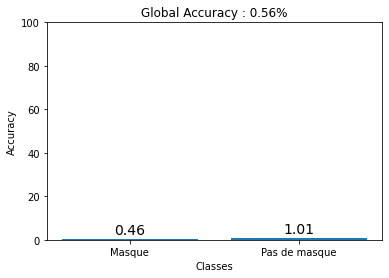

In [ ]:
plot_classes_predictions(y_train, y_train_pred)

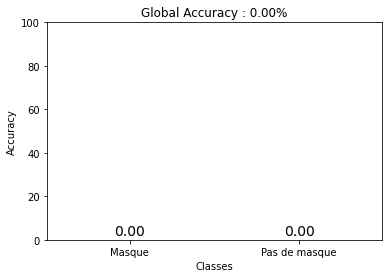

In [ ]:
plot_classes_predictions(y_val,y_val_pred)

In [ ]:
print("training IoU {}".format(get_iou(y_train, y_train_pred)))
print("Validation IoU {}".format(get_iou(y_val, y_val_pred)))

training IoU 0.0005179138159728015
Validation IoU 0.0021460671793457078


## Avec une loss adaptée

In [ ]:
true_boxes=Input(shape=(1, 1, 1, MAX_TRUE_BOX_PER_IMAGE , 4))
model_custom_loss = create_model_ft()
model_custom_loss.summary()

block5_conv1
block5_conv2
block5_conv3
block5_pool
(14, 14)
Model: "Fine-tuning"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 14, 14, 512)  14714688    input_13[0][0]                   
__________________________________________________________________________________________________
DetectionLayer (Conv2D)         (None, 7, 7, 35)     17955       model_4[1][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 7, 7, 5, 7)   0           DetectionLayer[0][0]             
____________________________

### Entrainement

In [ ]:
history_custom_loss = train(model_custom_loss, x_train, x_train_true_boxes, y_train, x_val, y_val, epochs=50, lr=1e-3, loss="custom")

Train on 106 samples, validate on 44 samples
Epoch 1/50
106/106 [==============================] - 75s 710ms/step - loss: 51.8253 - mae: 0.4262 - val_loss: 47.5734 - val_mae: 0.4544
Epoch 2/50
106/106 [==============================] - 75s 711ms/step - loss: 46.0531 - mae: 0.4912 - val_loss: 43.2814 - val_mae: 0.5658
Epoch 3/50
106/106 [==============================] - 75s 706ms/step - loss: 42.5107 - mae: 0.6236 - val_loss: 40.7857 - val_mae: 0.7163
Epoch 4/50
106/106 [==============================] - 79s 745ms/step - loss: 40.1701 - mae: 0.7751 - val_loss: 39.2009 - val_mae: 0.8626
Epoch 5/50
106/106 [==============================] - 76s 715ms/step - loss: 39.2143 - mae: 0.9114 - val_loss: 38.1488 - val_mae: 0.9891
Epoch 6/50
106/106 [==============================] - 76s 715ms/step - loss: 38.1453 - mae: 1.0321 - val_loss: 37.4126 - val_mae: 1.1031
Epoch 7/50
106/106 [==============================] - 75s 707ms/step - loss: 37.1932 - mae: 1.1360 - val_loss: 36.8919 - val_mae: 1.1

### Analyse de l'entrainement

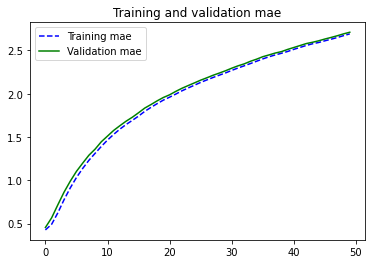

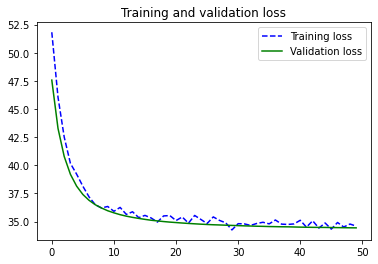

In [ ]:
plot_training_analysis_mse(history_custom_loss)

In [ ]:
y_val_pred= model_custom_loss.predict([x_val, x_val_true_boxes])
y_train_pred= model_custom_loss.predict([x_train, x_train_true_boxes])

In [ ]:
y_val_pred.shape

(44, 7, 7, 5, 7)

[(3, 1)]


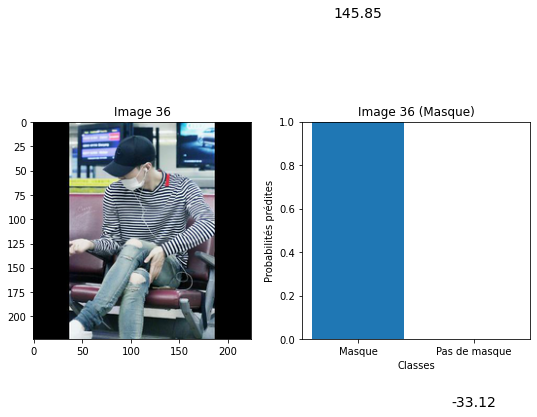

[(1, 2), (4, 2)]


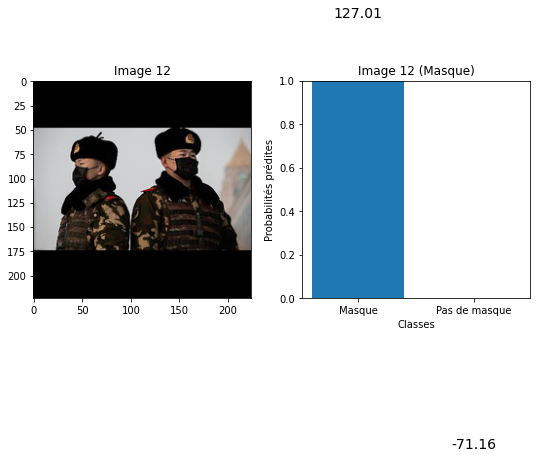

[(0, 2), (1, 2), (3, 2), (4, 2), (6, 2)]


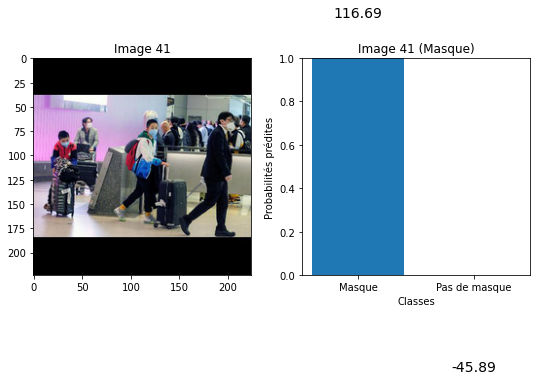

In [ ]:
print_rd_predictions(x_val, y_val, y_val_pred)

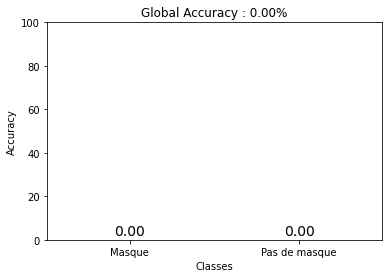

In [ ]:
plot_classes_predictions(y_train, y_train_pred)

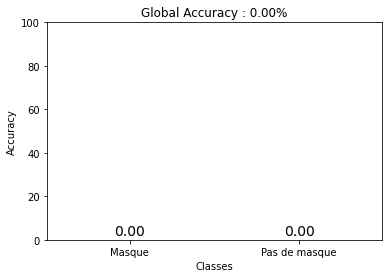

In [ ]:
plot_classes_predictions(y_val,y_val_pred)

In [ ]:
print("training IoU {}".format(get_iou(y_train, y_train_pred)))
print("Validation IoU {}".format(get_iou(y_val, y_val_pred)))

training IoU 0.0
Validation IoU 0.0
